# This ipynb tries to duplicate the result by Chad DeChant on MNIST small 
(http://llcao.net/cu-deeplearning15/programming_problem.html).
There are two key components in Chad's work: (1)RMSprop and (2) dropout. Currently I have left IBM and I don't have a GPU so I only try (1) but not (2). RMSProp is motivated by the idea of rprop, which use the sign of gradient to control the learning rate. However, rprop's idea conflicts with mini-batch, so RMSprop keeps a moving average of root square mean (rms) of gradient 

You may refer to layer_for_theano/dropout_layer for the second technique

In [1]:
import sys
sys.path.append('../../')
from layer_for_theano import *
import matplotlib.pyplot as plt
%matplotlib inline

load dataset in 2.8 secs
(50000L, 1L, 14L, 14L)


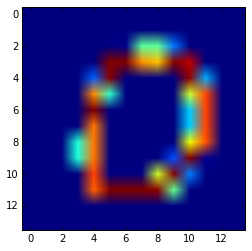

In [3]:
import cPickle
import numpy as np
import gzip

import time

class dataset_mnist_small_3d:
    def __init__(self):
        if 0: # no requirement for gzip, but big file
            f = open('mnist_14x14.pkl', 'rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()
        else: # requiring gzip           
            f = gzip.open('mnist_14x14.pkl.gz','rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()

        xs_tr, ys_tr = train_set
        xs_val, ys_val = valid_set
        xs_te, ys_te = test_set
        
        self.xs_tr = xs_tr.reshape(xs_tr.shape[0],1,14,14)
        self.xs_te = xs_te.reshape(xs_te.shape[0],1,14,14)
        self.xs_val = xs_val.reshape(xs_val.shape[0],1,14,14)       

        self.ys_tr =  ys_tr.astype(np.int32)
        self.ys_val = ys_val.astype(np.int32)
        self.ys_te =  ys_te.astype(np.int32)

t0 = time.time()
        
ds =  dataset_mnist_small_3d()  
print 'load dataset in %.1f secs' % (time.time()-t0)

print ds.xs_tr.shape

plt.imshow(ds.xs_te[10,0])
plt.show()

In [4]:
from sgd_for_theano import *
class cnn_small(tt_sgd_model):
    def __init__(self):
        #784
        #dim = 196
        nc = 10

        self.layers = []
        self.layers += [Input2DLayer(500, 1, 14, 14)]

        nonlinearfunc = T.tanh #T.nnet.sigmoid #rectify #rectify
        print 'nonlinear activation function = ', nonlinearfunc
        
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[20,1,3,3], activation=nonlinearfunc)]
        self.layers += [Conv2DLayer(self.layers[-1], filter_shape=[50,20,3,3], activation=nonlinearfunc)]
        
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = 500,  activation = T.tanh)]
        #self.layers += [ HiddenLayer(self.layers[-1], n_out = nc,  activation = None)]
        
        self.layers += [FlattenLayer(self.layers[-1])]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 900, activation=nonlinearfunc)]
        self.layers += [HiddenLayer(self.layers[-1], n_out = 10)]
        
        self.layers +=  [ SoftmaxLayer(self.layers[-1])]

        target = T.ivector('target')
        output_eval = self.layers[-1].output()
        self.cost_eval = mcloss_negli(output_eval, target)
        self.err_eval = mc_error(output_eval, target)
        self.validate_model = theano.function([self.layers[0].input, target], self.err_eval)
        self.cost_model = theano.function([self.layers[0].input, target], self.cost_eval)

        output_tr = self.layers[-1].output(dropout_training=True)
        self.cost_tr = mcloss_negli(output_eval, target)

        #learning_rate = 0.13
        learning_rate = 0.05
        #all_para = all_parameters(self.layers[-1])
        all_para = self.get_all_parameters()
        #updates = gen_updates_sgd(self.cost_tr, all_para, learning_rate)
        updates = get_update_rmsprop(self.cost_tr, all_para, learning_rate)
        self.train_model = theano.function([self.layers[0].input, target], self.cost_tr, updates=updates)

model = cnn_small()

if 1: #unit test
    import sys
    model._unit_test(ds.xs_tr[0:100], ds.ys_tr[0:100])
    #sys.exit(0)

nonlinear activation function =  Elemwise{tanh,no_inplace}
before training, err= 0.81
now training, cost =  2.32192439759
after training, err= 0.62


2.38603730082 2.51600516617 2.48442189147 2.5650708771 2.25276033855 2.58062512547 2.44936385521 2.34376047589 1.98720676371 2.07605620835 2.19429773953 1.9482491117 1.9498042681 1.79294636708 1.7337699346 1.77222714281 1.67784915865 1.59139065515 1.50026602359 1.56505117079 1.6351955473 1.54557475594 1.62018370223 1.52859701584 1.43005893742 1.51628577503 1.57918972309 1.56061799537 1.32190195951 1.41703341844 1.28462140262 1.33205404164 1.37112638036 1.51781846018 1.35078363762 1.28816743419 1.35109941713 1.34133776412 1.37012879458 1.29101685865 1.2752802567 1.30845261867 1.37495600646 1.35070746678 1.23026136652 1.28914030829 1.34596652131 1.56071387251 1.35074083789 1.31906855071 1.32512824997 1.35538278507 1.34648902303 1.29044160711 1.28753023102 1.35238309322 1.50486817737 1.32942929728 1.32153757482 1.26616725971 1.26899425551 1.32183315574 1.33236459386 1.28762963397 1.30354667792 1.31995013593 1.2859856133 1.31434779357 1.27441590825 1.24379832452 1.26529722696 1.22662523461

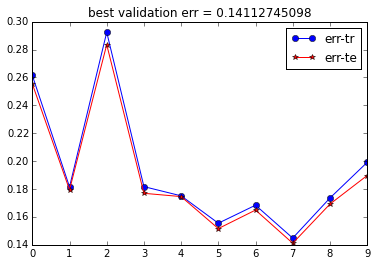

In [5]:
best_err, best_model,err_list_val, err_list_tr =  sgd_batch(model, ds.xs_tr, ds.ys_tr, ds.xs_te, ds.ys_te, batch_size=600, n_epochs=10, verbose=2)

plt.plot(err_list_tr,'bo-',label='err-tr')
plt.plot(err_list_val,'r*-',label='err-te')
plt.legend()
plt.title('best validation err = ' + str(best_err))
plt.show()